In [238]:
import numpy as np
import nengo
import nengo.spa as spa
import world
import kitchen
import nodes
import matplotlib.pyplot as plt
%matplotlib inline

D = 256

test_world = kitchen.get_kitchen()
test_world.print_state()

effects = ['WATER_IN_KETTLE', 'KETTLE_UNDER_TAP', 'WATER_BOILED', 'KETTLE_PLUGGED_IN', 'KETTLE_UNPLUGGED', 'KETTLE']
action_set = ['FILL_KETTLE_FROM_TAP', 'PUT_KETTLE_UNDER_TAP', 'BOIL_KETTLE', 'PLUG_IN_KETTLE','UNPLUG_KETTLE','KETTLE']
precons = ['KETTLE_UNDER_TAP','KETTLE_UNPLUGGED','WATER_IN_KETTLE','HAS_CORD']

effect_vocab = spa.Vocabulary(D)
action_vocab = spa.Vocabulary(D)
precon_vocab = spa.Vocabulary(D)

# Cycle of control signals
cycle_items = ['GET_ACTION','GET_PRECON','SET_GOAL']
cycle_vocab = spa.Vocabulary(D)

for item in cycle_items:
    cycle_vocab.parse(item)

for effect in effects:
    effect_vocab.parse(effect)
    
for action in action_set:
    action_vocab.parse(action)

for precon in precons:
    precon_vocab.parse(precon)  

action_vocab['INDEX'].make_unitary()

WATER
{'TEMPERATURE': 'COLD'}
------------------
KETTLE
{'PLUGGED': 'PLUGGED_IN'}
ON-COUNTER
------------------
TAP
{'OFFON': 'OFF'}
------------------
COUNTER
{}
------------------


In [239]:
motor_sys = nodes.MotorSystem(action_vocab, test_world)

with spa.SPA(label='Stack Test') as model:

    # For producing sequence of goals to push to stack
    model.ctrl_sig = spa.Memory(dimensions=D, vocab=cycle_vocab, synapse=0.01, tau=0.06) 

    model.goal = spa.Memory(dimensions=D, vocab=effect_vocab, synapse=0.005, tau=0.05)
    model.action = spa.Memory(dimensions=D, vocab=action_vocab, synapse=0.005, tau=0.05)
    model.precon = spa.Memory(dimensions=D, vocab=precon_vocab, synapse=0.005, tau=0.05)

    model.action_to_precon = spa.AssociativeMemory(input_vocab=action_vocab, output_vocab=precon_vocab, 
                                                   input_keys=action_set[:4], output_keys=precons, 
                                                   threshold=0.3, wta_output=True)
    
    model.goal_to_action = spa.AssociativeMemory(input_vocab=effect_vocab, output_vocab=action_vocab, 
                                                 input_keys=effects, output_keys=action_set, 
                                                 threshold=0.3, wta_output=True)

    # Stack implementation
    model.push = spa.Memory(dimensions=D, vocab=action_vocab, synapse=0.005, tau=0.15)
    model.stack = spa.Memory(dimensions=D, vocab=action_vocab, synapse=0.005, tau=0.15)
    model.top = spa.Memory(dimensions=D, vocab=action_vocab, synapse=0.005, tau=0.05)
    model.clean = spa.AssociativeMemory(action_vocab, threshold=0.15)
    model.target_obj = spa.Buffer(dimensions=D, vocab=action_vocab)
    
    bg_actions = spa.Actions(
        'dot(ctrl_sig, GET_ACTION) -->  goal_to_action=1.5*goal, ctrl_sig=GET_PRECON',
        'dot(ctrl_sig, GET_PRECON) -->  action_to_precon=1.5*action, push=1.5*(stack*INDEX+action), ctrl_sig=SET_GOAL',
        'dot(ctrl_sig, SET_GOAL)   -->  goal=precon, stack=push, ctrl_sig=GET_ACTION',
        'dot(ctrl_sig, TOP_ACTION) -->  clean=stack, ctrl_sig=POP_ACTION',
        'dot(ctrl_sig, POP_ACTION) -->  push=(stack-top)*~INDEX, ctrl_sig=UPDATE',
        'dot(ctrl_sig, UPDATE)     -->  stack=10*push, ctrl_sig=TOP_ACTION',
        'dot(ctrl_sig, NULL)       -->  ',
        '0.3                       -->  ')

    model.bg = spa.BasalGanglia(bg_actions)
    model.thal = spa.Thalamus(model.bg)

    def set_goal(t):
        if 0.12 < t < 0.15: return 'WATER_BOILED'
        else: return '0'

    def set_target(t):
        return 'KETTLE'
        
    def set_plan(t):
        if 0.1 < t < 0.15: return 'GET_ACTION'
        if 0.56 < t < 0.6: return '2*NULL'
        if 0.61 < t < 0.66: return 'TOP_ACTION'
        else: return '0'

    model.start = spa.Input(goal=set_goal, ctrl_sig=set_plan, target_obj=set_target)


    model.motor = nengo.Node(motor_sys, size_in=2*D, size_out=1)
    
    nengo.Connection(model.action_to_precon.output, model.precon.state.input)
    nengo.Connection(model.goal_to_action.output, model.action.state.input)
    nengo.Connection(model.clean.output, model.top.state.input)

    nengo.Connection(model.target_obj.state.output, model.motor[:D])
    nengo.Connection(model.top.state.output, model.motor[D:])
    
    goal_probe = nengo.Probe(model.goal.state.output, synapse=0.03)
    plan_probe = nengo.Probe(model.ctrl_sig.state.output, synapse=0.03)
    action_probe = nengo.Probe(model.action.state.output, synapse=0.03)
    precon_probe = nengo.Probe(model.precon.state.output, synapse=0.03)
    top_probe = nengo.Probe(model.top.state.output, synapse=0.03)
    stack_probe = nengo.Probe(model.stack.state.output, synapse=0.03)
    push_probe = nengo.Probe(model.push.state.output, synapse=0.03)
    motor_probe = nengo.Probe(model.motor)
    target_probe = nengo.Probe(model.target_obj.state.output, synapse=0.03)
    goal_to_act_probe = nengo.Probe(model.goal_to_action.output, synapse=0.03)
    
sim = nengo.Simulator(model, seed=np.random.randint(1))

In [240]:
def plot_results_full(sim):
    fig = plt.figure(figsize=(18,12))

    p1 = fig.add_subplot(7,1,1)
    p1.plot(sim.trange(), model.similarity(sim.data, goal_probe))
    p1.legend(model.get_output_vocab('goal').keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=8)
    p1.set_ylabel('Goal')

    p2 = fig.add_subplot(7,1,2)
    p2.plot(sim.trange(), model.similarity(sim.data, plan_probe))
    p2.legend(model.get_output_vocab('ctrl_sig').keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=8)
    p2.set_ylabel('Control Signal')

    p3 = fig.add_subplot(7,1,3)
    p3.plot(sim.trange(), model.similarity(sim.data, action_probe))
    p3.legend(model.get_output_vocab('action').keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=8)
    p3.set_ylabel('Action')

    p4 = fig.add_subplot(7,1,4)
    p4.plot(sim.trange(), model.similarity(sim.data, precon_probe))
    p4.legend(model.get_output_vocab('precon').keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=8)
    p4.set_ylabel('Precondition')

    p5 = fig.add_subplot(7,1,5)
    p5.plot(sim.trange(), model.similarity(sim.data, push_probe))
    p5.legend(model.get_output_vocab('push').keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=8)
    p5.set_ylabel('Push')

    p6 = fig.add_subplot(7,1,6)
    p6.plot(sim.trange(), model.similarity(sim.data, stack_probe))
    p6.legend(model.get_output_vocab('stack').keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=8)
    p6.set_ylabel('Stack')

    p7 = fig.add_subplot(7,1,7)
    p7.plot(sim.trange(), model.similarity(sim.data, top_probe))
    p7.legend(model.get_output_vocab('top').keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=8)
    p7.set_ylabel('Popped')
    
    fig.subplots_adjust(hspace=0.75)
    plt.show()
    
def plot_interaction(sim):
    fig = plt.figure(figsize=(18,12))

    p1 = fig.add_subplot(2,1,1)
    p1.plot(sim.trange(), model.similarity(sim.data, target_probe))
    p1.legend(model.get_output_vocab('target_obj').keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=8)
    p1.set_ylabel('Target')

    p2 = fig.add_subplot(2,1,2)
    p2.plot(sim.trange(), model.similarity(sim.data, top_probe))
    p2.legend(model.get_output_vocab('top').keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=8)
    p2.set_ylabel('Action')

    fig.subplots_adjust(hspace=0.75)
    fig.show()

In [241]:
sim.reset()
sim.run(1)

[############################ 67% ########                     ] ETA: 0:00:12performing action UNPLUG_KETTLE with KETTLE
[############################ 91% #######################      ] ETA: 0:00:03performing action PUT_KETTLE_UNDER_TAP with KETTLE
Simulation finished in 0:00:34.                                                 


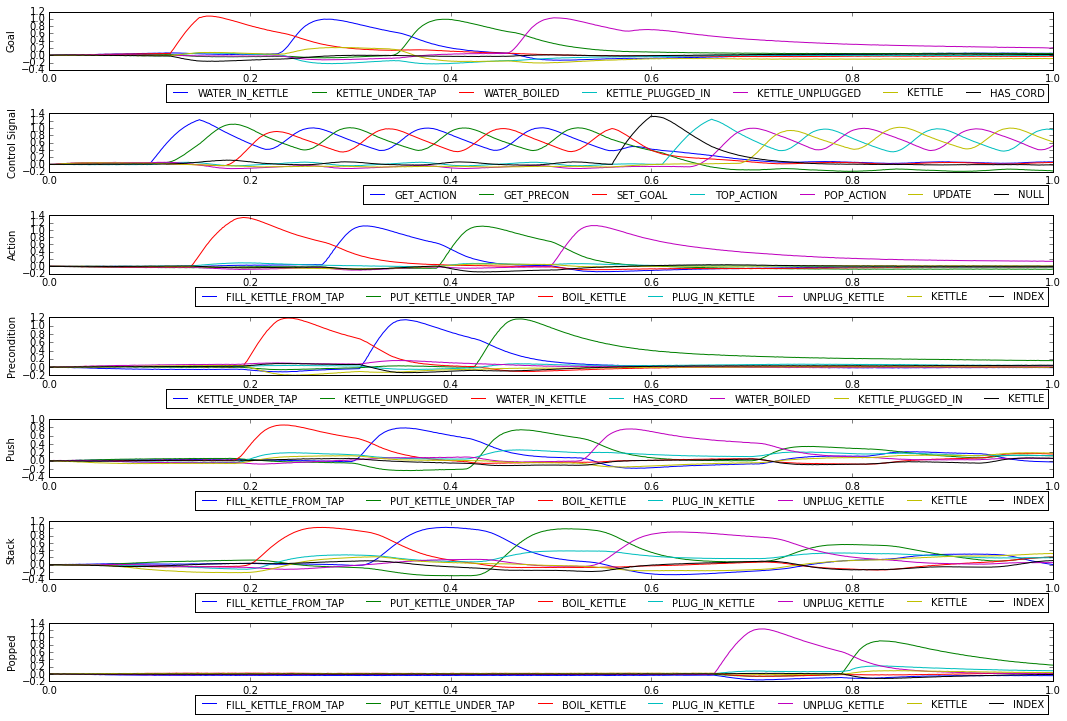

In [242]:
plot_results_full(sim)

In [243]:
# Test if model's stack can be used symbolically (i.e. whether failure is in popping stage)
def get_key(vocab, pointer, threshold):
    key = None
    similarities = vocab.dot(pointer)
    ind = np.argmax(similarities)
    print similarities[ind]
    if similarities[ind] >= threshold:
        key = vocab.keys[ind]
    return key

stack = sim.data[stack_probe][600]
top = get_key(action_vocab, stack, 0.3)
print top

stack = spa.pointer.SemanticPointer(stack - action_vocab[top].v) * ~action_vocab['INDEX']
top = get_key(action_vocab, stack, 0.3)
print top

stack = spa.pointer.SemanticPointer(stack.v - action_vocab[top].v) * ~action_vocab['INDEX']
top = get_key(action_vocab, stack, 0.3)
print top

0.842466872193
UNPLUG_KETTLE
0.557519084303
PUT_KETTLE_UNDER_TAP
0.503691990644
FILL_KETTLE_FROM_TAP


In [ ]:
test_world.print_state()